In [23]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc

from wcd_vae.data import prep_data
from wcd_vae.metrics import ilisi_graph, clisi_graph
from wcd_vae.scCRAFT.model import train_integration_model, obtain_embeddings
from wcd_vae.scCRAFT.utils import set_seed
from wcd_vae.plot import plot_umap_by_technology

# set random seed for reproducibility
set_seed(42)

Load Pacreas data

In [24]:
pancreas_adata = prep_data("/workspaces/data/human_pancreas_norm_complexBatch.h5ad", 
                  batch_key="tech", 
                  celltype_key="celltype",
                  batch_count=2,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

Before batch deconfounding

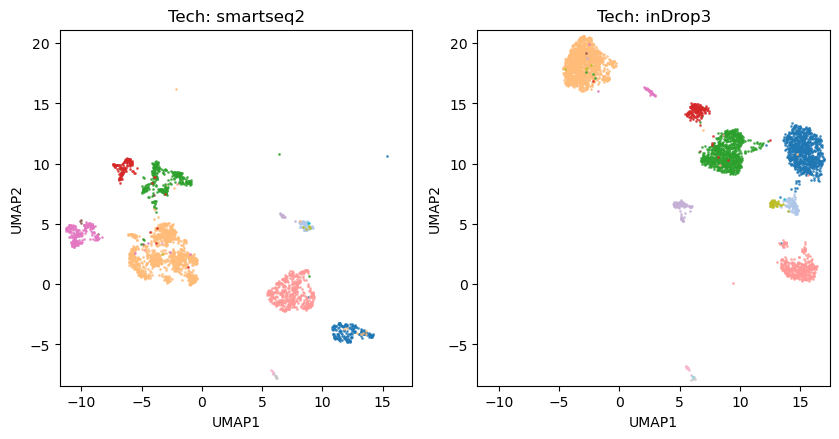

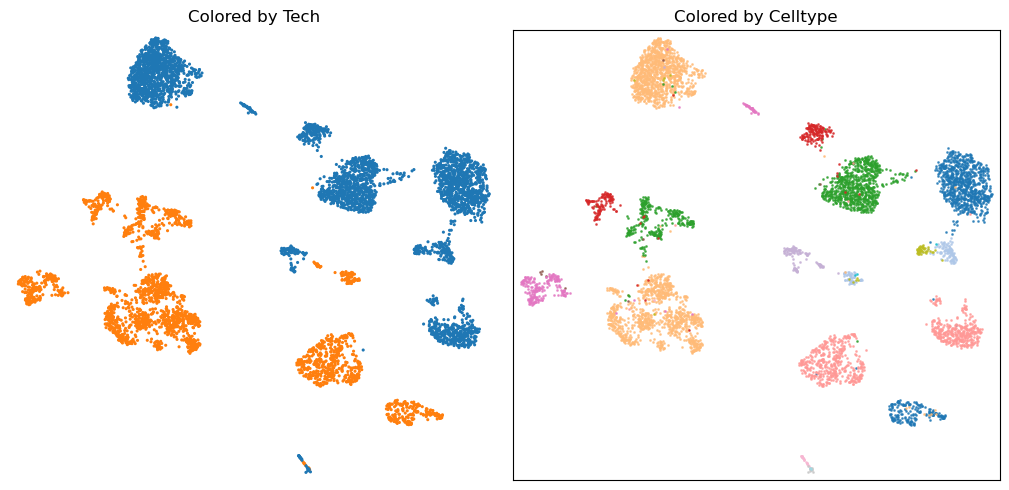

In [25]:
plot_umap_by_technology(pancreas_adata, batch_key='tech', color_key='celltype')

Train model with Wasserstein Critic and plot UMAP

Using device: cuda
500
Training completed in 54.93 seconds


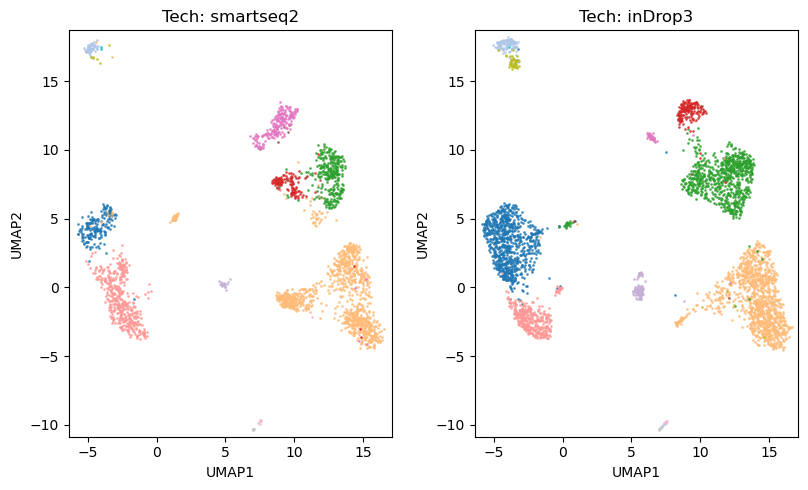

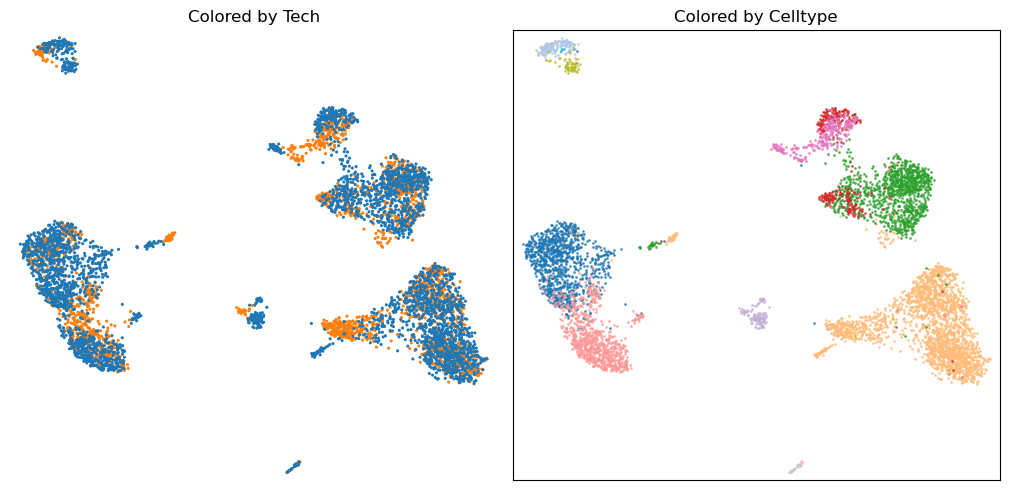

Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for tech...
Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for celltype...
iLISI: 0.647, cLISI: 0.012


In [31]:
model = train_integration_model(pancreas_adata, batch_key = 'tech', z_dim=256, d_coef = 0.1, epochs=500, critic=True, disc_iter=10)
obtain_embeddings(pancreas_adata, model.to("cuda:0"))
sc.pp.neighbors(pancreas_adata, use_rep="X_scCRAFT")
plot_umap_by_technology(pancreas_adata, batch_key='tech', color_key='celltype')

obtain_embeddings(pancreas_adata, model)

In [ ]:
# Compute validation scores
ilisi_val = ilisi_graph(
    pancreas_adata, batch_key='tech', type="embed", use_rep="X_scCRAFT"
)
clisi_val = clisi_graph(
    pancreas_adata, label_key='celltype', type="embed", use_rep="X_scCRAFT"
)

print(f"iLISI: {ilisi_val:.3f}, cLISI: {clisi_val:.3f}")

Using device: cuda
100
Training completed in 11.11 seconds


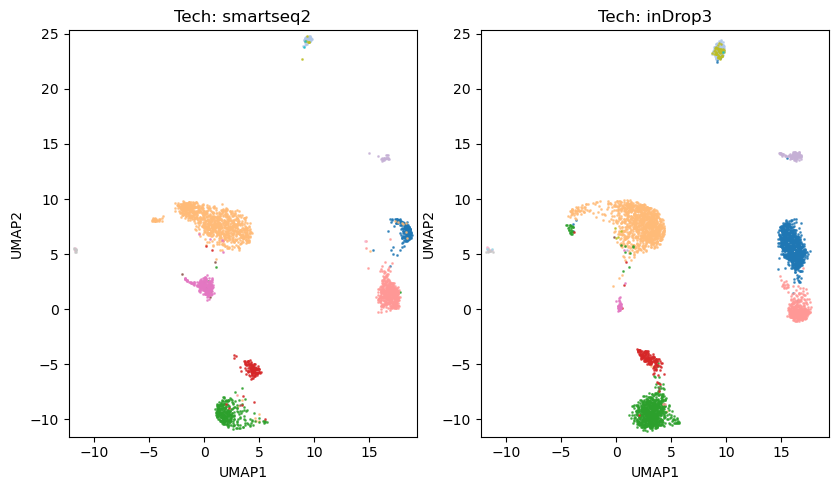

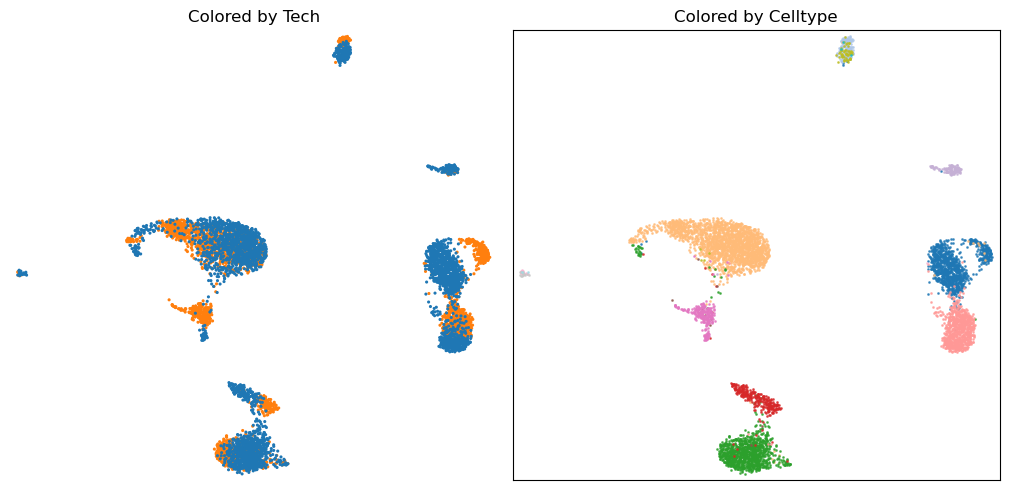

Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for tech...
Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for celltype...
iLISI: 0.454, cLISI: 0.005


In [29]:
model = train_integration_model(pancreas_adata, batch_key = 'tech', z_dim=256, d_coef = 0.1, epochs=100, critic=True, disc_iter=10)
obtain_embeddings(pancreas_adata, model.to("cuda:0"))
sc.pp.neighbors(pancreas_adata, use_rep="X_scCRAFT")
plot_umap_by_technology(pancreas_adata, batch_key='tech', color_key='celltype')

obtain_embeddings(pancreas_adata, model)

# Compute validation scores
ilisi_val = ilisi_graph(
    pancreas_adata, batch_key='tech', type="embed", use_rep="X_scCRAFT"
)
clisi_val = clisi_graph(
    pancreas_adata, label_key='celltype', type="embed", use_rep="X_scCRAFT"
)

print(f"iLISI: {ilisi_val:.3f}, cLISI: {clisi_val:.3f}")

Using device: cuda
500
Training completed in 41.90 seconds


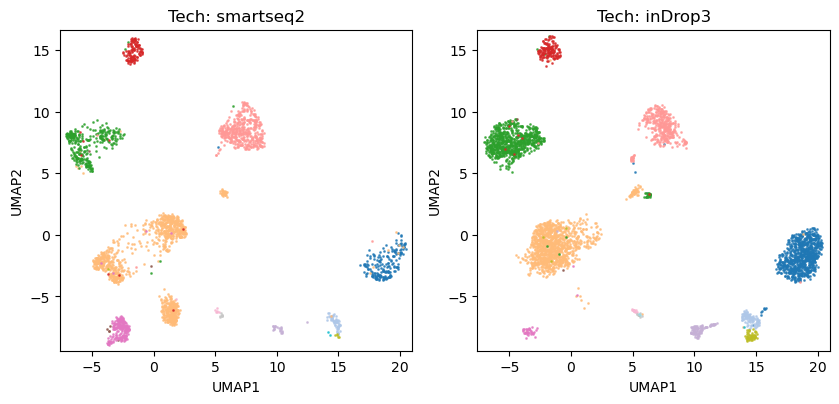

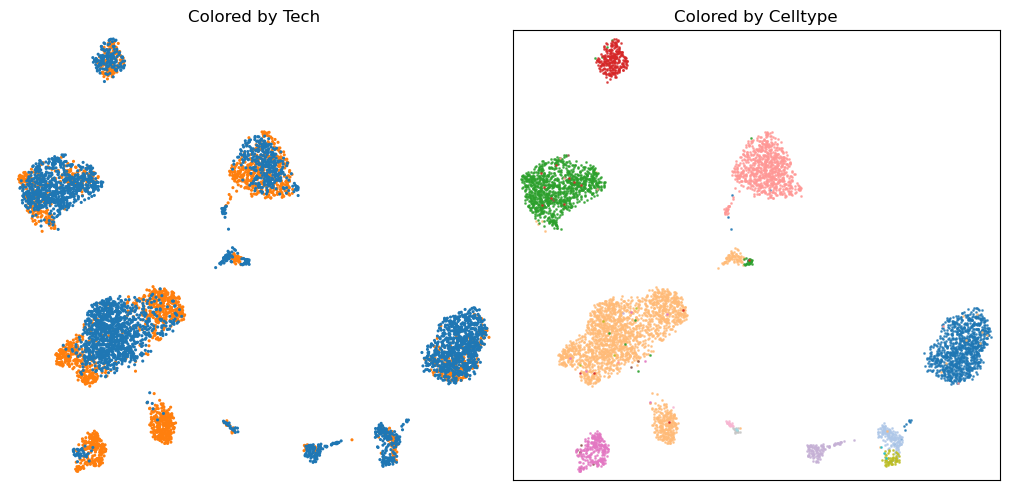

Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for tech...
Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for celltype...
iLISI: 0.466, cLISI: 0.003


In [28]:
model = train_integration_model(pancreas_adata, batch_key = 'tech', z_dim=256, d_coef = 0.05, epochs=500, critic=False, disc_iter=1)
obtain_embeddings(pancreas_adata, model.to("cuda:0"))
sc.pp.neighbors(pancreas_adata, use_rep="X_scCRAFT")
plot_umap_by_technology(pancreas_adata, batch_key='tech', color_key='celltype')

# Compute validation scores
ilisi_val = ilisi_graph(
    pancreas_adata, batch_key='tech', type="embed", use_rep="X_scCRAFT"
)
clisi_val = clisi_graph(
    pancreas_adata, label_key='celltype', type="embed", use_rep="X_scCRAFT"
)

print(f"iLISI: {ilisi_val:.3f}, cLISI: {clisi_val:.3f}")

Using device: cuda
100
Training completed in 8.35 seconds


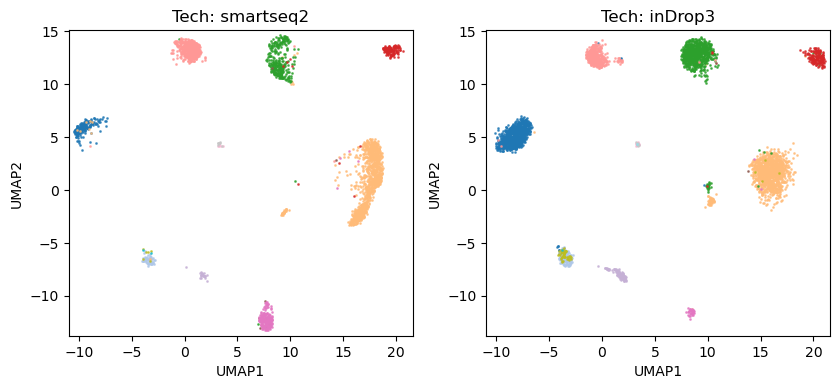

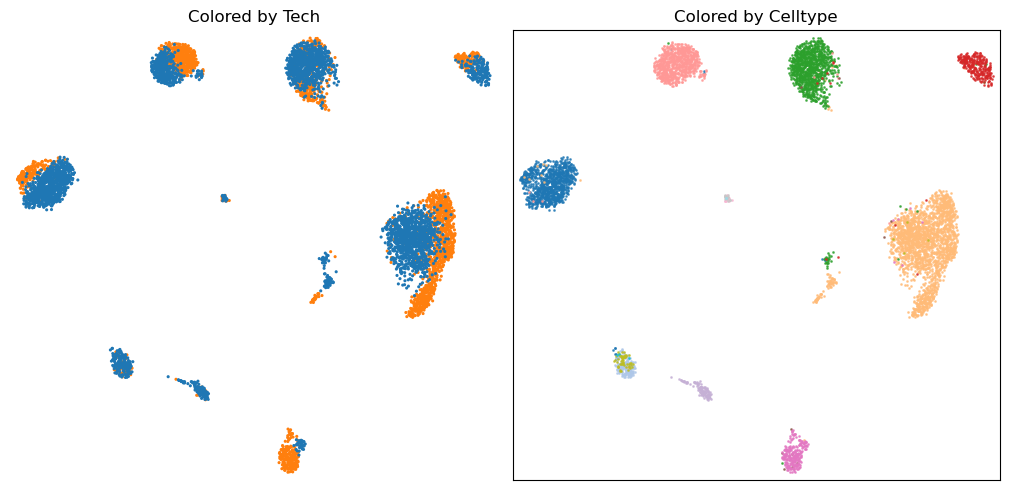

Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for tech...
Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for celltype...
iLISI: 0.373, cLISI: 0.004


In [30]:
model = train_integration_model(pancreas_adata, batch_key = 'tech', z_dim=256, d_coef = 0.05, epochs=100, critic=False, disc_iter=1)
obtain_embeddings(pancreas_adata, model.to("cuda:0"))
sc.pp.neighbors(pancreas_adata, use_rep="X_scCRAFT")
plot_umap_by_technology(pancreas_adata, batch_key='tech', color_key='celltype')

# Compute validation scores
ilisi_val = ilisi_graph(
    pancreas_adata, batch_key='tech', type="embed", use_rep="X_scCRAFT"
)
clisi_val = clisi_graph(
    pancreas_adata, label_key='celltype', type="embed", use_rep="X_scCRAFT"
)

print(f"iLISI: {ilisi_val:.3f}, cLISI: {clisi_val:.3f}")